<a href="https://colab.research.google.com/github/varsita-yeddula/AIML_Learnings/blob/main/STP_Module_01_Lab_03_Data_Augmentation_by_Om.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

Module 1, Lab 3

In this lab, we will see how augmentation of data samples help in improving the machine learning performance. Augmentation is the process of creating new data samples by making reasonable modifications to the original data samples. This is particularly useful when the size of the training data is small. We will use the MNISt dataset for this lab. We will also reuse functions from the previous labs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp

rng = np.random.default_rng(seed=42)

### Why Data Augmentation?

**Problem:** Machine learning models need lots of data to learn well. Collecting data is expensive and time-consuming.

**Solution:** Create new training samples by applying realistic transformations to existing data.

### Key Concepts

**Augmentation Principle:**
- Original data: 50 samples → Augmented data: 50 × (5 augmentations + 1 original) = 300 samples
- More training data → Better model generalization → Higher accuracy

**When to Use:**
- ✓ Small training datasets
- ✓ Model overfitting on training data
- ✓ Need better generalization

**Important Rule:** Augmentations must preserve the label!
- ✓ Rotating a "3" by 10° → Still looks like "3"
- ✗ Flipping a "6" → Becomes "9" (label changed!)

---

In [2]:
# loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# normalizing the data
train_X = train_X / 255
test_X = test_X / 255

# subsample from images and labels. Otherwise it will take too long!
train_X = train_X[::1200, :, :].copy()
train_y = train_y[::1200].copy()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let us borrow a few functions from the previous labs:

In [3]:
def NN1(traindata, trainlabel, query):
    """
    This function takes in the training data, training labels and a query point
    and returns the predicted label for the query point using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    query: numpy array of shape (d,) where d is the number of features

    returns: the predicted label for the query point which is the label of the training data which is closest to the query point
    """
    diff = (
        traindata - query
    )  # find the difference between features. Numpy automatically takes care of the size here
    sq = diff * diff  # square the differences
    dist = sq.sum(1)  # add up the squares
    label = trainlabel[np.argmin(dist)]
    return label


def NN(traindata, trainlabel, testdata):
    """
    This function takes in the training data, training labels and test data
    and returns the predicted labels for the test data using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    testdata: numpy array of shape (m,d) where m is the number of test samples and d is the number of features

    returns: the predicted labels for the test data which is the label of the training data which is closest to each test point
    """
    traindata = traindata.reshape(-1, 28*28)
    testdata = testdata.reshape(-1, 28*28)
    predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
    return predlabel


def Accuracy(gtlabel, predlabel):
    """
    This function takes in the ground-truth labels and predicted labels
    and returns the accuracy of the classifier

    gtlabel: numpy array of shape (n,) where n is the number of samples
    predlabel: numpy array of shape (n,) where n is the number of samples

    returns: the accuracy of the classifier which is the number of correct predictions divided by the total number of predictions
    """
    assert len(gtlabel) == len(
        predlabel
    ), "Length of the ground-truth labels and predicted labels should be the same"
    correct = (
        gtlabel == predlabel
    ).sum()  # count the number of times the groundtruth label is equal to the predicted label.
    return correct / len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time. Let us first check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [4]:
testpred = NN(train_X, train_y, test_X)
print("Baseline accuracy without augmentation:",
      Accuracy(test_y, testpred)*100, "%")

Baseline accuracy without augmentation: 64.72 %


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. So, we will use the following augmentations:

### Augmentation 1: Rotation

Let us try rotating the image a little. We will use the `rotate` function from the `skimage` module. We will rotate the image by 10 degrees and -10 degrees. Rotation is a reasonable augmentation because the digit will still be recognizable even after rotation and is representative of the dataset.

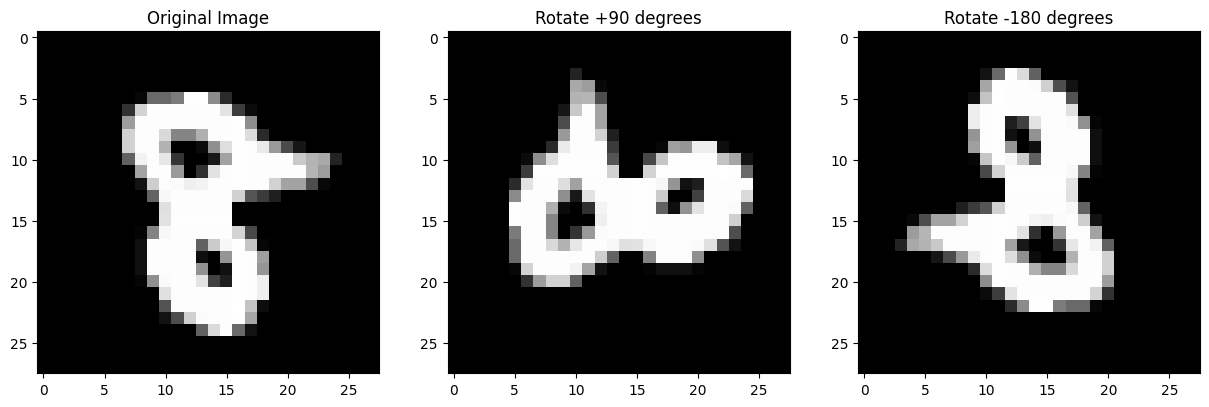

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(train_X[2], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(rotate(train_X[2], 90), cmap="gray")
axs[1].set_title("Rotate +90 degrees")

axs[2].imshow(rotate(train_X[2], -180), cmap="gray")
axs[2].set_title("Rotate -180 degrees")

plt.show()

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [13]:
def augRotate(sample, angleconstraint):
    """
    This function takes in a sample and an angle constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint
    """
    if angleconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(sample[ii], angle[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

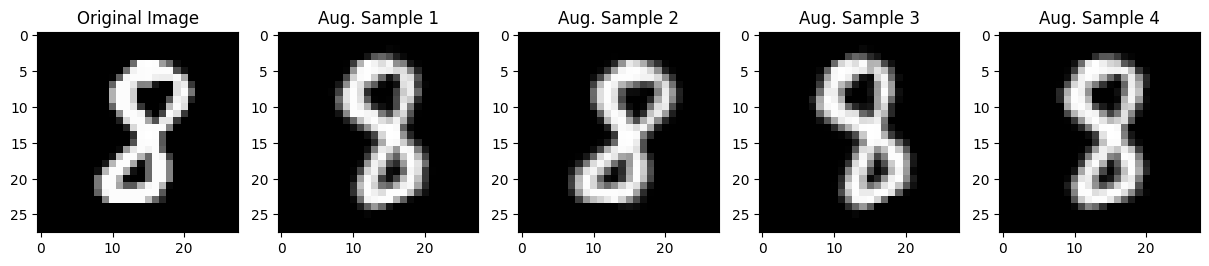

In [14]:
sample = train_X[20]
angleconstraint = 70

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[1].set_title("Aug. Sample 1")

axs[2].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[2].set_title("Aug. Sample 2")

axs[3].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[3].set_title("Aug. Sample 3")

axs[4].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[4].set_title("Aug. Sample 4")

plt.show()

Let us augment the whole dataset and see if this improves the test accuracy

In [15]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X  # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
    augdata = np.concatenate(
        (augdata, augRotate(train_X, angleconstraint))
    )  # concatenate the augmented data to the set
    auglabel = np.concatenate(
        (auglabel, train_y)
    )  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print("Accuracy after rotation augmentation:", Accuracy(test_y, testpred)*100, "%")

Accuracy after rotation augmentation: 67.66 %


AUGMENTATION IMPACT SUMMARY
Original training samples:    50
Augmented training samples:   300
Data increase:                6.0x

Baseline accuracy:            64.72%
After augmentation:           67.66%
Improvement:                  +2.94%


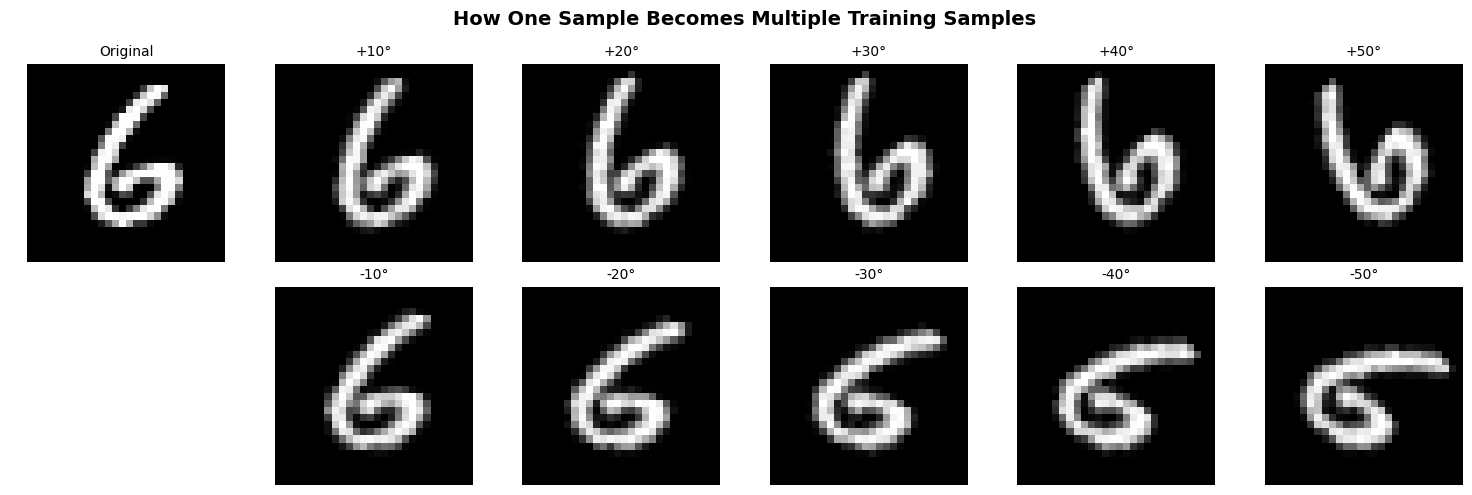

In [17]:
print("=" * 60)
print("AUGMENTATION IMPACT SUMMARY")
print("=" * 60)

original_size = len(train_X)
augmented_size = len(augdata)
baseline_acc = 64.72
augmented_acc = 67.66

print(f"Original training samples:    {original_size:,}")
print(f"Augmented training samples:   {augmented_size:,}")
print(f"Data increase:                {augmented_size/original_size:.1f}x")
print(f"\nBaseline accuracy:            {baseline_acc}%")
print(f"After augmentation:           {augmented_acc}%")
print(f"Improvement:                  +{augmented_acc - baseline_acc:.2f}%")
print("=" * 60)

# Visualize: Show how one digit gets augmented
fig, axes = plt.subplots(2, 6, figsize=(15, 5))
sample_digit = train_X[5]  # Pick one sample

axes[0, 0].imshow(sample_digit, cmap='gray')
axes[0, 0].set_title('Original', fontsize=10)
axes[0, 0].axis('off')

# Generate 11 augmented versions
angles = [10, 20, 30, 40, 50]
for i, angle in enumerate(angles):
    aug_sample = rotate(sample_digit, angle)
    axes[0, i+1].imshow(aug_sample, cmap='gray')
    axes[0, i+1].set_title(f'+{angle}°', fontsize=10)
    axes[0, i+1].axis('off')

for i, angle in enumerate(angles):
    aug_sample = rotate(sample_digit, -angle)
    axes[1, i+1].imshow(aug_sample, cmap='gray')
    axes[1, i+1].set_title(f'-{angle}°', fontsize=10)
    axes[1, i+1].axis('off')

axes[1, 0].axis('off')
plt.suptitle('How One Sample Becomes Multiple Training Samples',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

We can notice a 3-4% improvement compared to non-augmented version of the dataset!

The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint. We will try angles between 0 and 90 degrees. We can also try different multiples of the original dataset. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [18]:
angleconstraints = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # the values we want to test
accuracies = np.zeros(
    len(angleconstraints), dtype=float
)  # we will save the values here

for ii in range(len(angleconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotate(train_X, angleconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after rotation augmentation constrained by",
        angleconstraints[ii],
        "degrees is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after rotation augmentation constrained by 0 degrees is 64.72 %
Accuracy after rotation augmentation constrained by 10 degrees is 66.79 %
Accuracy after rotation augmentation constrained by 20 degrees is 67.84 %
Accuracy after rotation augmentation constrained by 30 degrees is 68.47 %
Accuracy after rotation augmentation constrained by 40 degrees is 67.63 %
Accuracy after rotation augmentation constrained by 50 degrees is 67.65 %
Accuracy after rotation augmentation constrained by 60 degrees is 65.3 %
Accuracy after rotation augmentation constrained by 70 degrees is 66.06 %
Accuracy after rotation augmentation constrained by 80 degrees is 64.61 %
Accuracy after rotation augmentation constrained by 90 degrees is 64.31 %


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

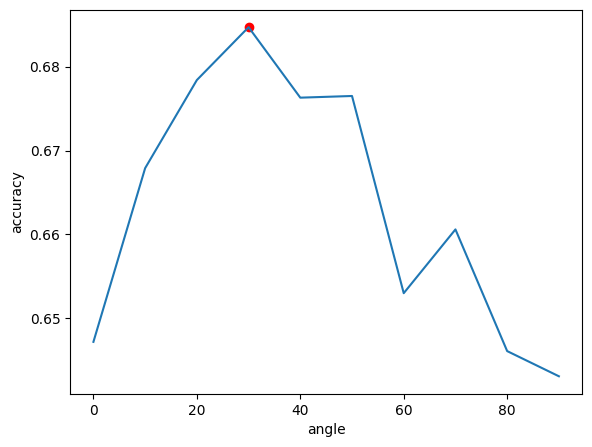

In [19]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 2: Shear


Let us try one more augmentation: shear. Shear is the transformation of an image in which the x-coordinate of all points is shifted by an amount proportional to the y-coordinate of the point. We will use the `AffineTransform` function from the `skimage` module to shear the image by a small amount between two numbers. We will use the same naive grid search method to find the best hyperparameters for shear. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [20]:
def shear(sample, amount):
    """
    This function takes in a sample and an amount and returns the augmented sample
    by shearing the sample by the given amount

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    amount: the amount by which the sample should be sheared

    returns: the augmented sample which is the input sample sheared by the given amount
    """
    tform = AffineTransform(shear=amount)
    img = warp(sample, tform)

    # Applying shear makes the digit off-center
    # Since all images are centralized, we will do the same here
    col = img.sum(0).nonzero()[0]
    row = img.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(sample.shape[0] / 2 - (row[0] + row[-1]) / 2)
        yshift = int(sample.shape[1] / 2 - (col[0] + col[-1]) / 2)
        img = np.roll(img, (xshift, yshift), (0, 1))
    return img

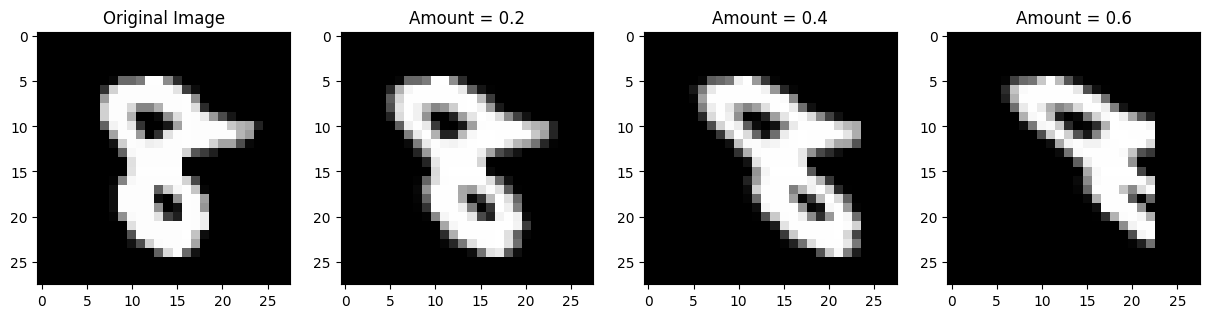

In [21]:
sample = train_X[2]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(shear(sample, 0.2), cmap="gray")
axs[1].set_title("Amount = 0.2")

axs[2].imshow(shear(sample, 0.4), cmap="gray")
axs[2].set_title("Amount = 0.4")

axs[3].imshow(shear(sample, 0.6), cmap="gray")
axs[3].set_title("Amount = 0.6")

plt.show()

Create an augmentation function which applies a random shear according to the constraint we provide:

In [22]:
def augShear(sample, shearconstraint):
    """
    This function takes in a sample and a shear constraint and returns the augmented sample
    by shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample sheared by a random amount within the shear constraint
    """
    if shearconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = shear(sample[ii], amt[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [23]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
    1.8,
    2.0,
]  # the values we want to test
accuracies = np.zeros(
    len(shearconstraints), dtype=float
)  # we will save the values here

for ii in range(len(shearconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augShear(train_X, shearconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after shear augmentation constrained by",
        shearconstraints[ii],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0.2 is 62.79 %
Accuracy after shear augmentation constrained by 0.4 is 64.41 %
Accuracy after shear augmentation constrained by 0.6 is 65.71000000000001 %
Accuracy after shear augmentation constrained by 0.8 is 65.78 %
Accuracy after shear augmentation constrained by 1.0 is 65.42999999999999 %
Accuracy after shear augmentation constrained by 1.2 is 63.6 %
Accuracy after shear augmentation constrained by 1.4 is 63.65 %
Accuracy after shear augmentation constrained by 1.6 is 61.809999999999995 %
Accuracy after shear augmentation constrained by 1.8 is 63.029999999999994 %
Accuracy after shear augmentation constrained by 2.0 is 64.14 %


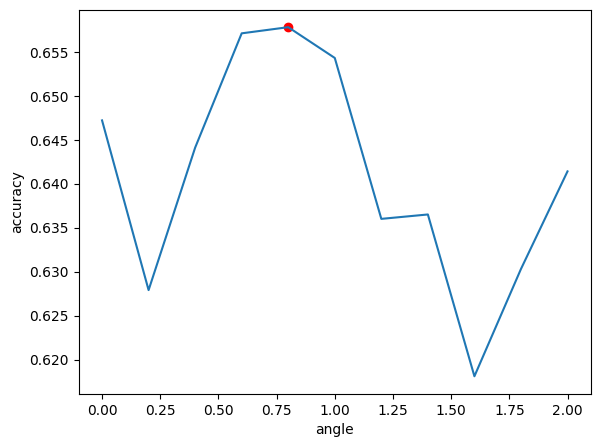

In [24]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 3: Rotation + Shear



We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [25]:
def augRotateShear(sample, angleconstraint, shearconstraint):
    """
    This function takes in a sample, an angle constraint and a shear constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint and shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint and sheared by a random amount within the shear constraint
    """
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(
            shear(sample[ii], amt[ii]), angle[ii]
        )  # first apply shear, then rotate
    return np.squeeze(nsample)  # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [26]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
]  # the values we want to test
angleconstraints = [0, 10, 20, 30, 40, 50, 60]  # the values we want to test
# cartesian product of both
hyp = cartesian((shearconstraints, angleconstraints))

accuracies = np.zeros(len(hyp), dtype=float)  # we will save the values here

for ii in range(len(hyp)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation shear:",
        hyp[ii][0],
        "angle:",
        hyp[ii][1],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation shear: 0.0 angle: 0.0 is 63.32 %
Accuracy after augmentation shear: 0.0 angle: 10.0 is 63.959999999999994 %
Accuracy after augmentation shear: 0.0 angle: 20.0 is 60.64000000000001 %
Accuracy after augmentation shear: 0.0 angle: 30.0 is 63.019999999999996 %
Accuracy after augmentation shear: 0.0 angle: 40.0 is 64.14999999999999 %
Accuracy after augmentation shear: 0.0 angle: 50.0 is 61.72 %
Accuracy after augmentation shear: 0.0 angle: 60.0 is 63.7 %
Accuracy after augmentation shear: 0.2 angle: 0.0 is 63.41 %
Accuracy after augmentation shear: 0.2 angle: 10.0 is 61.25000000000001 %
Accuracy after augmentation shear: 0.2 angle: 20.0 is 60.6 %
Accuracy after augmentation shear: 0.2 angle: 30.0 is 60.07 %
Accuracy after augmentation shear: 0.2 angle: 40.0 is 63.690000000000005 %
Accuracy after augmentation shear: 0.2 angle: 50.0 is 60.12 %
Accuracy after augmentation shear: 0.2 angle: 60.0 is 63.72 %
Accuracy after augmentation shear: 0.4 angle: 0.0 is 63.37000

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

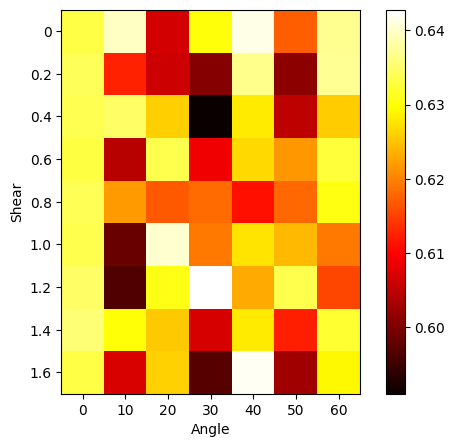

In [27]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap="hot"
)
ax.set_xlabel("Angle")
ax.set_ylabel("Shear")
ax.set_xticks(np.arange(len(angleconstraints)))
ax.set_xticklabels(angleconstraints)
ax.set_yticks(np.arange(len(shearconstraints)))
ax.set_yticklabels(shearconstraints)
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

# Answers
1. The best value for angle constraint was 68.47% (for 30 degrees) and the best value for shear contraint was 65.78 (for the value 0.8). The baseline accuracy was 64.72%. So, there was an improvement of 3.75% and 1.06% respectively.

2. Based on the observations, the accuracy increased the introduction of augmentations. With the increase in the number of augmentations, the accuracy can also further increase as the model will be training on larger data but it is possible the the accuracy might become stagnant after reaching certain threshold number of augmentations

3. Other augmentations like flipping, adding noise and blurring are executed below:

In [33]:
#Flipping the images
def augFlip(sample):

    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = np.fliplr(sample[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

In [36]:
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augFlip(train_X))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after shear augmentation constrained by is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after shear augmentation constrained by is 62.38 %


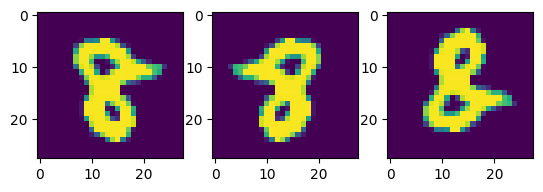

In [45]:
fig, axs = plt.subplots(1,3)
axs[0].imshow(sample)
axs[1].imshow(augFlip(sample))
axs[2].imshow(np.flipud(sample))

In [53]:
#Adding noise to the images
from skimage.util import random_noise

def augNoise(sample, noiseconstraint):
    if noiseconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * noiseconstraint  # make the random shear constrained
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = random_noise(sample[ii], var = amt[ii]**2)
    return np.squeeze(nsample)  # take care if the input had only one sample.

In [59]:
noiseconstraints = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

accuracies = np.zeros(len(noiseconstraints), dtype=float)  # we will save the values here

for ii in range(len(noiseconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augNoise(train_X, noiseconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation adding noise:",
        noiseconstraints[ii],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation adding noise: 0 is 64.72 %
Accuracy after augmentation adding noise: 0.1 is 64.27000000000001 %
Accuracy after augmentation adding noise: 0.2 is 64.19 %
Accuracy after augmentation adding noise: 0.3 is 64.64999999999999 %
Accuracy after augmentation adding noise: 0.4 is 64.59 %
Accuracy after augmentation adding noise: 0.5 is 64.61 %
Accuracy after augmentation adding noise: 0.6 is 64.18 %
Accuracy after augmentation adding noise: 0.7 is 64.16 %
Accuracy after augmentation adding noise: 0.8 is 64.29 %
Accuracy after augmentation adding noise: 0.9 is 64.32 %


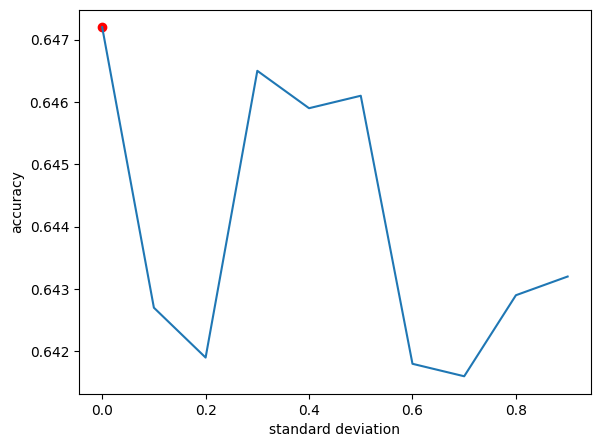

In [64]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(noiseconstraints, accuracies)
ax.set_xlabel("standard deviation")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(noiseconstraints[maxind], accuracies[maxind], c="red")

In [69]:
#Adding blur filter to the images
from skimage.filters import gaussian

def augBlur(sample, blurconstraint):
    if blurconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * blurconstraint  # make the random shear constrained
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = gaussian(sample[ii], sigma=amt,multichannel=True)
    return np.squeeze(nsample)  # take care if the input had only one sample.

In [70]:
blurconstraints = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

accuracies = np.zeros(len(blurconstraints), dtype=float)  # we will save the values here

for ii in range(len(blurconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augNoise(train_X, blurconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation adding noise:",
        blurconstraints[ii],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation adding noise: 0 is 64.72 %
Accuracy after augmentation adding noise: 0.5 is 64.1 %
Accuracy after augmentation adding noise: 1 is 64.75 %
Accuracy after augmentation adding noise: 1.5 is 64.66 %
Accuracy after augmentation adding noise: 2 is 64.33 %
Accuracy after augmentation adding noise: 2.5 is 64.67 %
Accuracy after augmentation adding noise: 3 is 64.86 %
Accuracy after augmentation adding noise: 3.5 is 64.38000000000001 %
Accuracy after augmentation adding noise: 4 is 64.64 %


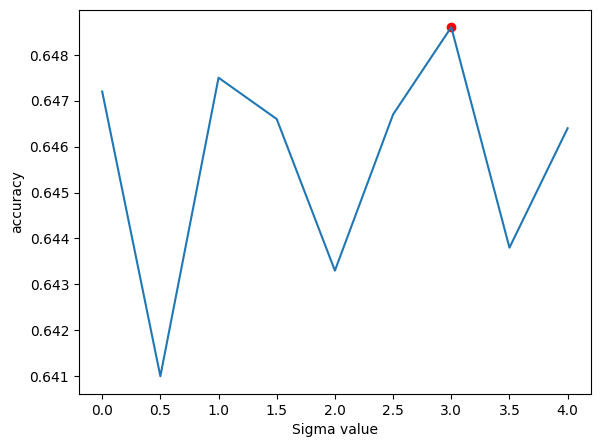

In [71]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(blurconstraints, accuracies)
ax.set_xlabel("Sigma value")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(blurconstraints[maxind], accuracies[maxind], c="red")

4. Various combinations of the augmentations can include:

In [88]:
#Combining noise and blur filter
from skimage.filters import gaussian
from skimage.util import random_noise

def augNoiseBlur(sample, noiseconstraint, blurconstraint):

    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for blur sigma
    amt = (amt - 0.5) * blurconstraint  # make the random blur constrained
    amt2 = rng.random(len(sample))  # generate random numbers for noise variance
    # make the random noise constrained
    amt2 = (amt2 - 0.5) * noiseconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        # Apply noise then blur
        noisy_sample = random_noise(sample[ii], var = amt2[ii] ** 2)
        nsample[ii] = gaussian(noisy_sample, sigma=abs(amt[ii])) # Pass scalar amt[ii] as sigma
    return np.squeeze(nsample)  # take care if the input had only one sample.

In [89]:
noiseconstraints = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

blurconstraints = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

hyp = cartesian((noiseconstraints, blurconstraints))

accuracies = np.zeros(len(hyp), dtype=float)  # we will save the values here

for ii in range(len(hyp)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augNoiseBlur(train_X, hyp[ii][0], hyp[ii][1]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation shear:",
        hyp[ii][0],
        "angle:",
        hyp[ii][1],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation shear: 0.0 angle: 0.0 is 64.72 %
Accuracy after augmentation shear: 0.0 angle: 0.5 is 64.74 %
Accuracy after augmentation shear: 0.0 angle: 1.0 is 64.77000000000001 %
Accuracy after augmentation shear: 0.0 angle: 1.5 is 66.24 %
Accuracy after augmentation shear: 0.0 angle: 2.0 is 69.19 %
Accuracy after augmentation shear: 0.0 angle: 2.5 is 69.59 %
Accuracy after augmentation shear: 0.0 angle: 3.0 is 69.73 %
Accuracy after augmentation shear: 0.0 angle: 3.5 is 71.32 %
Accuracy after augmentation shear: 0.0 angle: 4.0 is 70.71 %
Accuracy after augmentation shear: 0.1 angle: 0.0 is 64.44 %
Accuracy after augmentation shear: 0.1 angle: 0.5 is 64.49000000000001 %
Accuracy after augmentation shear: 0.1 angle: 1.0 is 63.42 %
Accuracy after augmentation shear: 0.1 angle: 1.5 is 66.9 %
Accuracy after augmentation shear: 0.1 angle: 2.0 is 67.97999999999999 %
Accuracy after augmentation shear: 0.1 angle: 2.5 is 69.45 %
Accuracy after augmentation shear: 0.1 angle: 3.0 

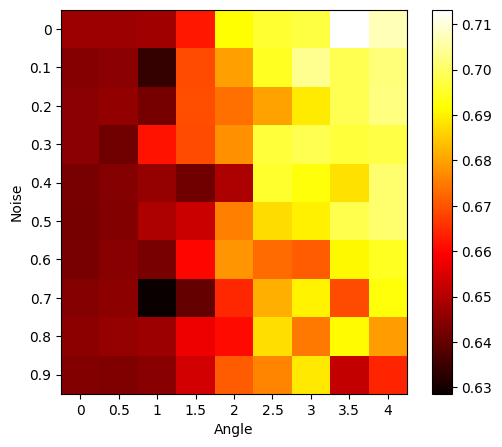

In [90]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(noiseconstraints), len(blurconstraints))), cmap="hot"
)
ax.set_xlabel("Angle")
ax.set_ylabel("Noise")
ax.set_xticks(np.arange(len(blurconstraints)))
ax.set_xticklabels(blurconstraints)
ax.set_yticks(np.arange(len(noiseconstraints)))
ax.set_yticklabels(noiseconstraints)
plt.colorbar(im)

In [95]:
#Combining rotation and blur filter

def augRotateBlur(sample, angleconstraint, blurconstraint):

    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for blur sigma
    amt = (amt - 0.5) * blurconstraint  # make the random blur constrained
    amt2 = rng.random(len(sample))  # generate random numbers for noise variance
    # make the random noise constrained
    amt2 = (amt2 - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        # Apply noise then blur
        noisy_sample = rotate(sample[ii],amt2[ii])
        nsample[ii] = gaussian(noisy_sample, sigma=abs(amt[ii])) # Pass scalar amt[ii] as sigma
    return np.squeeze(nsample)  # take care if the input had only one sample.

In [96]:
hyp = cartesian((angleconstraints, blurconstraints))

accuracies = np.zeros(len(hyp), dtype=float)  # we will save the values here

for ii in range(len(hyp)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotateBlur(train_X, hyp[ii][0], hyp[ii][1]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation shear:",
        hyp[ii][0],
        "angle:",
        hyp[ii][1],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation shear: 0.0 angle: 0.0 is 64.72 %
Accuracy after augmentation shear: 0.0 angle: 0.5 is 64.75 %
Accuracy after augmentation shear: 0.0 angle: 1.0 is 64.64 %
Accuracy after augmentation shear: 0.0 angle: 1.5 is 67.49000000000001 %
Accuracy after augmentation shear: 0.0 angle: 2.0 is 68.46 %
Accuracy after augmentation shear: 0.0 angle: 2.5 is 69.69999999999999 %
Accuracy after augmentation shear: 0.0 angle: 3.0 is 70.32000000000001 %
Accuracy after augmentation shear: 0.0 angle: 3.5 is 69.49 %
Accuracy after augmentation shear: 0.0 angle: 4.0 is 70.86 %
Accuracy after augmentation shear: 10.0 angle: 0.0 is 67.41 %
Accuracy after augmentation shear: 10.0 angle: 0.5 is 67.13 %
Accuracy after augmentation shear: 10.0 angle: 1.0 is 67.16 %
Accuracy after augmentation shear: 10.0 angle: 1.5 is 68.12 %
Accuracy after augmentation shear: 10.0 angle: 2.0 is 69.3 %
Accuracy after augmentation shear: 10.0 angle: 2.5 is 69.08999999999999 %
Accuracy after augmentation shea

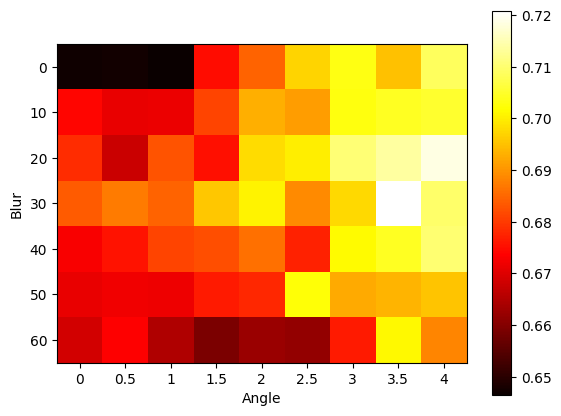

In [97]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(angleconstraints), len(blurconstraints))), cmap="hot"
)
ax.set_xlabel("Angle")
ax.set_ylabel("Blur")
ax.set_xticks(np.arange(len(blurconstraints)))
ax.set_xticklabels(blurconstraints)
ax.set_yticks(np.arange(len(angleconstraints)))
ax.set_yticklabels(angleconstraints)
plt.colorbar(im)

In [98]:
#Combining shear and blur filter

def augRotateBlur(sample, shearconstraint, blurconstraint):

    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for blur sigma
    amt = (amt - 0.5) * blurconstraint  # make the random blur constrained
    amt2 = rng.random(len(sample))  # generate random numbers for noise variance
    # make the random noise constrained
    amt2 = (amt2 - 0.5) * shearconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        # Apply noise then blur
        noisy_sample = shear(sample[ii],amt2[ii])
        nsample[ii] = gaussian(noisy_sample, sigma=abs(amt[ii])) # Pass scalar amt[ii] as sigma
    return np.squeeze(nsample)  # take care if the input had only one sample.

In [99]:
hyp = cartesian((shearconstraints, blurconstraints))

accuracies = np.zeros(len(hyp), dtype=float)  # we will save the values here

for ii in range(len(hyp)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotateBlur(train_X, hyp[ii][0], hyp[ii][1]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation shear:",
        hyp[ii][0],
        "blur:",
        hyp[ii][1],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation shear: 0.0 blur: 0.0 is 63.32 %
Accuracy after augmentation shear: 0.0 blur: 0.5 is 63.31 %
Accuracy after augmentation shear: 0.0 blur: 1.0 is 64.28 %
Accuracy after augmentation shear: 0.0 blur: 1.5 is 62.56 %
Accuracy after augmentation shear: 0.0 blur: 2.0 is 60.8 %
Accuracy after augmentation shear: 0.0 blur: 2.5 is 64.2 %
Accuracy after augmentation shear: 0.0 blur: 3.0 is 63.55 %
Accuracy after augmentation shear: 0.0 blur: 3.5 is 62.629999999999995 %
Accuracy after augmentation shear: 0.0 blur: 4.0 is 64.0 %
Accuracy after augmentation shear: 0.2 blur: 0.0 is 62.79 %
Accuracy after augmentation shear: 0.2 blur: 0.5 is 63.239999999999995 %
Accuracy after augmentation shear: 0.2 blur: 1.0 is 63.91 %
Accuracy after augmentation shear: 0.2 blur: 1.5 is 62.470000000000006 %
Accuracy after augmentation shear: 0.2 blur: 2.0 is 61.519999999999996 %
Accuracy after augmentation shear: 0.2 blur: 2.5 is 63.09 %
Accuracy after augmentation shear: 0.2 blur: 3.0 is

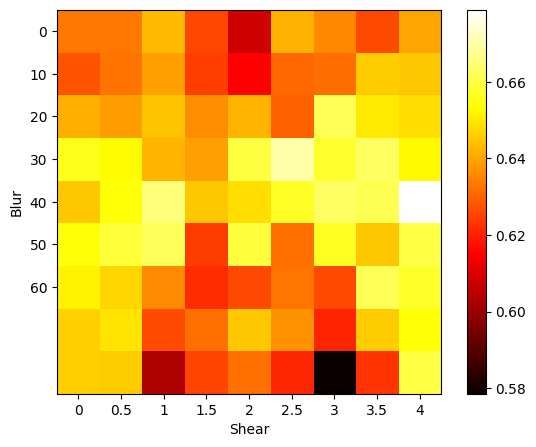

In [101]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(shearconstraints), len(blurconstraints))), cmap="hot"
)
ax.set_xlabel("Shear")
ax.set_ylabel("Blur")
ax.set_xticks(np.arange(len(blurconstraints)))
ax.set_xticklabels(blurconstraints)
ax.set_yticks(np.arange(len(angleconstraints)))
ax.set_yticklabels(angleconstraints)
plt.colorbar(im)

> Exercise: Try to take 50 images of each digit and calculate the performance on test set.

In [114]:
# hyperparameters
angleconstraint = 30
naugmentations = 49

digits_images = []
digits_labels = []
for i in range(10):

  index = np.where(train_y == i)[0][0]
  digits_images.append(train_X[index])
  digits_labels.append(train_y[index])

digits_images = np.array(digits_images)
digits_labels = np.array(digits_labels)

augdata = digits_images
auglabel = digits_labels

for i in range(len(digits_images)):
    original_image = digits_images[i]
    original_label = digits_labels[i]

    augmented_samples = []
    for _ in range(naugmentations):
       augmented_samples.append(augRotate(original_image, angleconstraint))

    augmented_samples = np.array(augmented_samples)

    augmented_labels = np.full(len(augmented_samples), original_label)

    augdata = np.concatenate((augdata, augmented_samples))
    auglabel = np.concatenate((auglabel, augmented_labels))

testpred = NN(augdata, auglabel, test_X)
print("Accuracy after rotation augmentation:", Accuracy(test_y, testpred)*100, "%")

Accuracy after rotation augmentation: 51.13999999999999 %
